In [1]:
# 库模块导入
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 加载并规范化CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 超参数1
batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12957190.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


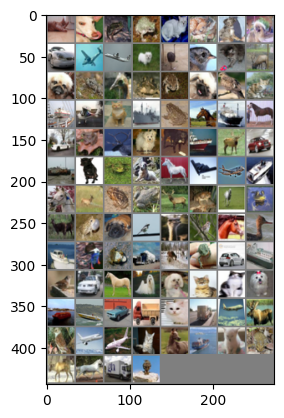

In [3]:
# 展示预训练图像

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
# 定义卷积神经网络

# 1.定义VGG网络基本块

"""
# in_channels：输入的通道数，即输入特征图的深度。
# out_channels：输出的通道数，即卷积核的数量，也是输出特征图的深度。
# num_layers：卷积层的数量
"""

def block(in_channels, out_channels, num_layers):
    layers = []
    for i in range(num_layers):
        # 添加卷积层
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
        """
        # kernel_size = 3：卷积核的大小为 3x3
        # padding=1：在输入特征图的四周各填充一行/列的零。
        """
        layers.append(nn.BatchNorm2d(out_channels))
        # 添加ReLU激活函数层
        layers.append(nn.ReLU(inplace=True))
        # 更新输入通道数
        in_channels = out_channels
    # 添加最大池化层
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
    """
    # kernel_size=2: 池化核大小为 2x2
    # stride=2: 池化步幅为 2,将输入特征图的尺寸减半。
    """
    # 封装layers并返回作为基本块的输出
    return nn.Sequential(*layers)


# 2.定义VGG网络

# 使用ImageNet上预训练的VGG16模型构建特征网络
class VGG16(nn.Module):

    # 定义VCC类自身的成员变量
    def __init__(self):
        super(VGG16, self).__init__()

        # 基本块顺序组合成网络结构
        self.layer1 = block(3, 64, 2)
        self.layer2 = block(64, 128, 2)
        self.layer3 = block(128, 256, 3)
        self.layer4 = block(256, 512, 3)
        self.layer5 = block(512, 512, 3)

        # 定义多线性层对经过特征提取的数据进行分类
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Dropout()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace = True),
            nn.Dropout()
        )
        self.fc3 = nn.Linear(256, 10)

    #  定义向前传播函数
    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

# 创建网络模型
device = torch.device("cuda:0")
net = VGG16()
net = net.to(device)

cat   dog   frog  frog  cat   deer  dog   dog   car   plane plane dog   bird  bird  cat   deer  dog   frog  bird  frog  frog  dog   bird  cat   ship  plane cat   ship  frog  horse ship  horse car   frog  deer  dog   dog   ship  deer  car   ship  dog   frog  dog   horse plane plane ship  horse deer  frog  frog  deer  frog  horse frog  deer  frog  dog   bird  bird  bird  horse bird  ship  bird  frog  truck horse frog  car   ship  bird  car   horse dog   dog   cat   cat   dog   ship  ship  car   truck cat   truck plane deer  bird  plane plane cat   horse ship  cat   frog  deer  horse truck bird 


In [5]:
# 定义绘制loss曲线函数
def DrawLoss(file_name, label_name):

    with open(file_name, 'r') as f:
        raw_data = f.read()
        # [-1:1]是为了去除文件中的前后中括号"[]"
        data = raw_data[1:-1].split(",")

    y_loss = np.asfarray(data, float)
    x_loss = range(len(y_loss))
    plt.figure()

    # 去除顶部和右侧边框
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlabel('iters')    # x轴标签
    plt.ylabel('loss')     # y轴标签

    # 以x_loss为横坐标，y_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
    # 默认颜色，如果想更改颜色，可以增加参数color='red',这是红色。
    plt.plot(x_loss, y_loss, linewidth=1, linestyle="solid", label=label_name)
    plt.legend()
    plt.title('Loss curve')
    plt.show()


In [6]:
# 定义损失函数和优化器
import torch.optim as optim

# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 超参数2
learning_rate = 0.001

# 使用优化器
# 超参数3
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, momentum=0.9)

In [7]:
# 训练网络

# 记录训练loss
train_loss = []
# 开始训练
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            train_loss.append(running_loss/100)
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.156
[1,   200] loss: 1.778
[1,   300] loss: 1.590
[1,   400] loss: 1.437
[1,   500] loss: 1.320
[2,   100] loss: 1.198
[2,   200] loss: 1.134
[2,   300] loss: 1.068
[2,   400] loss: 1.035
[2,   500] loss: 0.995
[3,   100] loss: 0.849
[3,   200] loss: 0.825
[3,   300] loss: 0.836
[3,   400] loss: 0.809
[3,   500] loss: 0.781
[4,   100] loss: 0.641
[4,   200] loss: 0.654
[4,   300] loss: 0.654
[4,   400] loss: 0.665
[4,   500] loss: 0.633
[5,   100] loss: 0.484
[5,   200] loss: 0.505
[5,   300] loss: 0.521
[5,   400] loss: 0.537
[5,   500] loss: 0.536
[6,   100] loss: 0.366
[6,   200] loss: 0.395
[6,   300] loss: 0.420
[6,   400] loss: 0.427
[6,   500] loss: 0.440
[7,   100] loss: 0.289
[7,   200] loss: 0.321
[7,   300] loss: 0.345
[7,   400] loss: 0.343
[7,   500] loss: 0.350
[8,   100] loss: 0.226
[8,   200] loss: 0.238
[8,   300] loss: 0.262
[8,   400] loss: 0.292
[8,   500] loss: 0.294
[9,   100] loss: 0.177
[9,   200] loss: 0.196
[9,   300] loss: 0.209
[9,   400] 

[2.1559460091590883, 1.7776925444602967, 1.5897146010398864, 1.4368741726875305, 1.3199868953227998, 1.1976973879337312, 1.134404218196869, 1.0684469491243362, 1.0350273281335831, 0.9948471581935883, 0.8493517249822616, 0.8252649891376496, 0.836267637014389, 0.8091321432590485, 0.7810945647954941, 0.6405495393276215, 0.6539395439624787, 0.6538988718390465, 0.6653772467374801, 0.6334918156266213, 0.4839344996213913, 0.5047429053485394, 0.5206171309947968, 0.5374926987290383, 0.5362655636668205, 0.3660371133685112, 0.39503373444080353, 0.42011961445212365, 0.4274226671457291, 0.4398892618715763, 0.2886572828888893, 0.32146483823657035, 0.34537189558148385, 0.3432067222893238, 0.35035266757011413, 0.22637813910841942, 0.23819347746670247, 0.2620623837411404, 0.2915227634459734, 0.2938686133921146, 0.17717221941798925, 0.19592361129820346, 0.209486315920949, 0.23127070732414723, 0.23509350091218947, 0.13795496959239245, 0.14379460204392672, 0.1817560188099742, 0.1762215143814683, 0.1979747

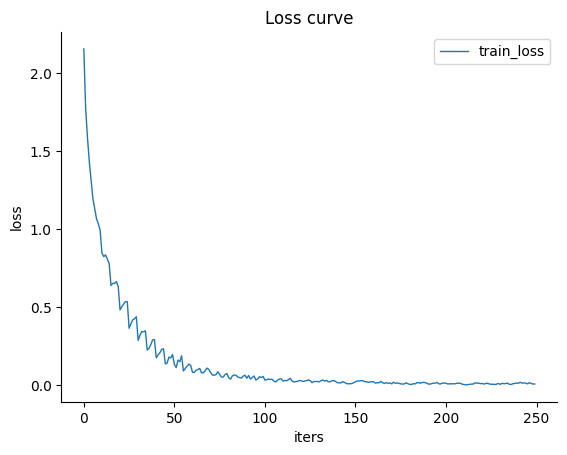

In [8]:
# 绘制train loss曲线
file_name_train = 'train_logs_batch4_lr0.0008_opSGD.txt'
with open(file_name_train,'w') as train_los:
    train_los.write(str(train_loss))
print(train_loss)
DrawLoss(file_name_train, "train_loss")

# 新段落

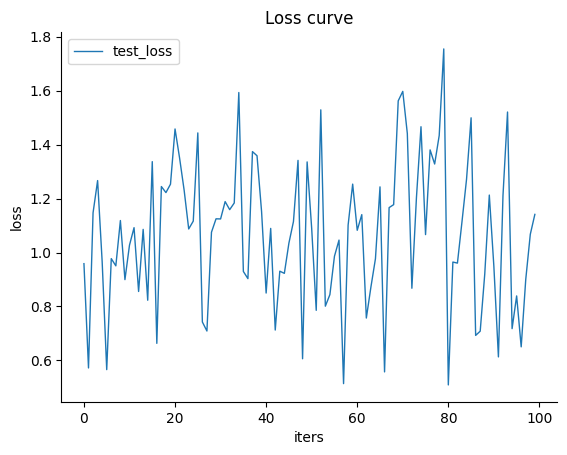

Accuracy of the network on the 10000 test images: 82 %


In [9]:
# 测试网络
correct = 0
total = 0

# 记录测试loss
test_loss = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = net(images)

        loss = criterion(outputs, labels)
        test_loss.append(loss.item())

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 绘制test loss曲线
file_name_test = 'test_logs_batch4_lr0.0008_opSGD.txt'
with open(file_name_test,'w') as test_los:
    test_los.write(str(test_loss))

DrawLoss(file_name_test, "test_loss")


# 整体精度
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')